In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
import pandas as pd

In [2]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionSmall(nn.Module):
    def __init__(self, num_classes = 10):
        super(InceptionSmall, self).__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)


Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=128, shuffle=False, num_workers=2)

In [5]:
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

device(type='cuda')

In [7]:
def fit(epoch, model, trainloader, testloader, optimizer,scheduler):
  history_t = {}
  history_v = {}
  criterion = nn.CrossEntropyLoss()
  for epoch in range(epoch):  
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()  
    acc_t = (correct / total)
    history_t[epoch+1] = acc_t
    scheduler.step()

    correct = 0
    total = 0
    for data in testloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()
    acc_v = (correct / total)
    history_v[epoch+1] = acc_v
    print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch+1, running_loss,acc_t, acc_v))
    log_ = str(epoch+1)+","+str(acc_t)+","+str(acc_v)+"\n"
    with open("model.log", "a") as f:
      f.write(log_)
  return model,history_t,history_v

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=32, shuffle=False, num_workers=2)
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t,history_v = fit(20, net, trainloader, testloader, optimizer,scheduler)

Epoch 1 | loss: 4090.1372 | Train acc: 9.9600 | Val acc: 10.0800
Epoch 2 | loss: 3599.7287 | Train acc: 10.3680 | Val acc: 11.6900
Epoch 3 | loss: 3553.0748 | Train acc: 12.8540 | Val acc: 16.4600
Epoch 4 | loss: 3217.4165 | Train acc: 22.9820 | Val acc: 29.9000
Epoch 5 | loss: 2834.9328 | Train acc: 32.7020 | Val acc: 38.9800
Epoch 6 | loss: 2563.1171 | Train acc: 39.6160 | Val acc: 42.8900
Epoch 7 | loss: 2351.8948 | Train acc: 45.2100 | Val acc: 46.9900
Epoch 8 | loss: 2157.6741 | Train acc: 50.3800 | Val acc: 51.6700
Epoch 9 | loss: 2005.9170 | Train acc: 54.1840 | Val acc: 54.9000
Epoch 10 | loss: 1869.4180 | Train acc: 57.3040 | Val acc: 56.9800
Epoch 11 | loss: 1762.8481 | Train acc: 60.0040 | Val acc: 58.6600
Epoch 12 | loss: 1668.8617 | Train acc: 62.2780 | Val acc: 60.6200
Epoch 13 | loss: 1583.2067 | Train acc: 64.3280 | Val acc: 62.6000
Epoch 14 | loss: 1505.0558 | Train acc: 66.0280 | Val acc: 63.1200
Epoch 15 | loss: 1442.6010 | Train acc: 67.4120 | Val acc: 65.3700
Epoch

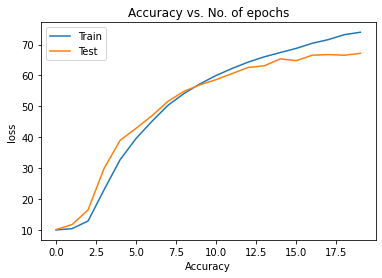

In [ ]:
plt.plot(list(history_t.values()),label='Train')
plt.plot(list(history_v.values()),label='Test')
plt.xlabel('Accuracy')
plt.ylabel('loss')
plt.title('Accuracy vs. No. of epochs')
plt.legend()
plt.show()

Epoch 1 | loss: 1199.2837 | Train acc: 0.1032 | Val acc: 0.1067
Epoch 2 | loss: 897.6040 | Train acc: 0.1059 | Val acc: 0.1111
Epoch 3 | loss: 892.2954 | Train acc: 0.1189 | Val acc: 0.1232
Epoch 4 | loss: 848.6075 | Train acc: 0.1822 | Val acc: 0.2347
Epoch 5 | loss: 770.2321 | Train acc: 0.2574 | Val acc: 0.2888
Epoch 6 | loss: 709.4081 | Train acc: 0.3213 | Val acc: 0.3718
Epoch 7 | loss: 641.0765 | Train acc: 0.3937 | Val acc: 0.4230
Epoch 8 | loss: 602.8583 | Train acc: 0.4311 | Val acc: 0.4287
Epoch 9 | loss: 577.6399 | Train acc: 0.4574 | Val acc: 0.4665
Epoch 10 | loss: 552.8545 | Train acc: 0.4824 | Val acc: 0.5021
Epoch 11 | loss: 530.6137 | Train acc: 0.5049 | Val acc: 0.5147
Epoch 12 | loss: 510.2016 | Train acc: 0.5268 | Val acc: 0.5365
Epoch 13 | loss: 493.3175 | Train acc: 0.5411 | Val acc: 0.5589
Epoch 14 | loss: 473.5434 | Train acc: 0.5612 | Val acc: 0.5616
Epoch 15 | loss: 457.2205 | Train acc: 0.5762 | Val acc: 0.5655
Epoch 16 | loss: 439.7495 | Train acc: 0.5948 | 

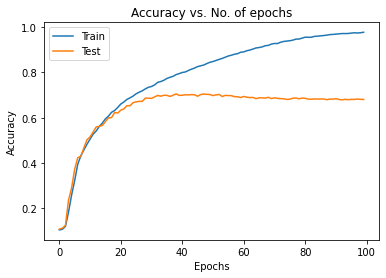

In [9]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=128, shuffle=False, num_workers=2)
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t,history_v = fit(100, net, trainloader, testloader, optimizer,scheduler)
plt.plot(list(history_t.values()),label='Train')
plt.plot(list(history_v.values()),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.legend()
plt.show()

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=False, num_workers=2)
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1 = fit(100, net, trainloader, testloader, optimizer,scheduler)
plt.plot(list(history_t1.values()),label='Train')
plt.plot(list(history_v1.values()),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.legend()
plt.show()

Epoch 1 | loss: 2006.7165 | Train acc: 0.1559 | Val acc: 0.2242
Epoch 2 | loss: 1477.7316 | Train acc: 0.3007 | Val acc: 0.3576
Epoch 3 | loss: 1302.0073 | Train acc: 0.3861 | Val acc: 0.4162
Epoch 4 | loss: 1201.1573 | Train acc: 0.4331 | Val acc: 0.4612
Epoch 5 | loss: 1127.8903 | Train acc: 0.4743 | Val acc: 0.4930
Epoch 6 | loss: 1054.9130 | Train acc: 0.5092 | Val acc: 0.5242
Epoch 7 | loss: 983.9896 | Train acc: 0.5462 | Val acc: 0.5503
Epoch 8 | loss: 919.5299 | Train acc: 0.5807 | Val acc: 0.5746
Epoch 9 | loss: 859.7834 | Train acc: 0.6080 | Val acc: 0.6073
Epoch 10 | loss: 810.0165 | Train acc: 0.6316 | Val acc: 0.6330
Epoch 11 | loss: 762.8690 | Train acc: 0.6536 | Val acc: 0.6338
Epoch 12 | loss: 715.3034 | Train acc: 0.6755 | Val acc: 0.6541
Epoch 13 | loss: 670.7213 | Train acc: 0.6972 | Val acc: 0.6652
Epoch 14 | loss: 633.2089 | Train acc: 0.7152 | Val acc: 0.6729
Epoch 15 | loss: 592.1438 | Train acc: 0.7334 | Val acc: 0.6907
Epoch 16 | loss: 556.4926 | Train acc: 0.75

In [ ]:
def fit(epoch, model, trainloader, testloader, optimizer,scheduler):
  history_t[0] = 0
  history_v[0] = 0
  correct_t = 0
  total_t = 0
  correct_v = 0
  total_v = 0
  ct = 0
  cv = 0
  criterion = nn.CrossEntropyLoss()
  for epoch in range(epoch):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        total_t += labels.size(0)
        correct_t += (preds == labels).sum().item()
        if total_t>=10000:
          acc_t = (correct_t / total_t)
          history_t[ct+1] = acc_t
          total_t = 0
          correct_t = 0
          ct+=1

    scheduler.step()

    for data in testloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1)
      total_v += labels.size(0)
      correct_v += (preds == labels).sum().item()
      if total_v>=10000:
        acc_v = (correct_v / total_v)
        history_v[cv+5] = acc_v
        total_v = 0
        correct_v = 0
        cv+=5     
    print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch+1, running_loss,acc_t, acc_v))
  return model,history_t,history_v